In [1]:
import timeit
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

color = sns.color_palette()
sns.set(style="white")

### Helper functions

In [2]:
def check_missing_val(df):  
    msg = 'missing data exists' if df.isnull().values.any() else 'no missing data'
    print(msg)

def plot_metric(param_list, metric_train_list, metric_test_list, xlabel, ylabel, title):
    params_list = [str(param) for param in param_list]
    plt.figure()
    plt.plot(param_list, metric_train_list, '-', color='r', label='train data')
    plt.plot(param_list, metric_test_list, '-', color='g', label='test data')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    
def clfLearner_cv(X, y, clf_learner, k_fold):
    '''get the score for train/test dataset using cross validation'''
    kf = KFold(n_splits=k_fold)
    metric_train_list_tmp, metric_test_list_tmp = [], []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf_learner.fit(X_train, y_train)
        y_pred_train = clf_learner.predict(X_train)
        y_pred_test = clf_learner.predict(X_test)
        metric_train_list_tmp.append(f1_score(y_train, y_pred_train, average='micro'))
        metric_test_list_tmp.append(f1_score(y_test, y_pred_test, average='micro'))
    return np.mean(metric_train_list_tmp), np.mean(metric_test_list_tmp)   


def plot_learner_graph(X, y, learner_func, learner_name, **args):
    '''score for train/test for paramX'''     
    start_time = timeit.default_timer() # timer
    f1_train, f1_test = [], []
    paramX_key = list(args['paramX'])[0]
    paramX_vals = args['paramX'][paramX_key]
    
    for paramX_val in paramX_vals:
        learner_params = {paramX_key: paramX_val}
        if 'helper_params' in args: learner_params.update(args['helper_params'])
        clf_learner = learner_func(**learner_params)
        metric_train, metric_test = clfLearner_cv(X, y, clf_learner, k_fold=10)
        f1_train.append(metric_train)
        f1_test.append(metric_test)

    plot_metric(paramX_vals, f1_train, f1_test, paramX_key, 'f1 score', learner_name)
    end_time = timeit.default_timer() # timer
    print(str(learner_name) +" model time (s):   "+"{:.5f}".format(end_time - start_time))

#### Phishing website data

In [3]:
# phishing data
df_pw = pd.read_csv(Path("phishing_website.csv"))

In [4]:
df_pw.head()

,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [5]:
df_pw.describe()

,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
count,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,...,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000
mean,0.313795,-0.633198,0.738761,0.700588,0.741474,-0.734962,0.063953,0.250927,-0.336771,0.628584,...,0.613388,0.816915,0.061239,0.377114,0.287291,-0.483673,0.721574,0.344007,0.719584,0.113885
std,0.949534,0.766095,0.673998,0.713598,0.671011,0.678139,0.817518,0.911892,0.941629,0.777777,...,0.789818,0.576784,0.998168,0.926209,0.827733,0.875289,0.692369,0.569944,0.694437,0.993539
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,-1.000000
50%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df_pw.columns

Index(['having_IPhaving_IP_Address', 'URLURL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length',
       'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL',
       'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe',
       'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank',
       'Google_Index', 'Links_pointing_to_page', 'Statistical_report',
       'Result'],
      dtype='object')

In [7]:
check_missing_val(df_pw)

no missing data


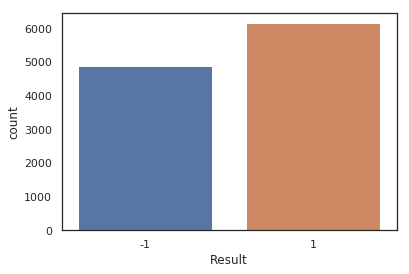

In [8]:
sns.countplot(x='Result', data=df_pw)
plt.show()

In [9]:
Xpw = df_pw.drop('Result', axis=1).values
Ypw = df_pw['Result'].values

##### Decision Trees

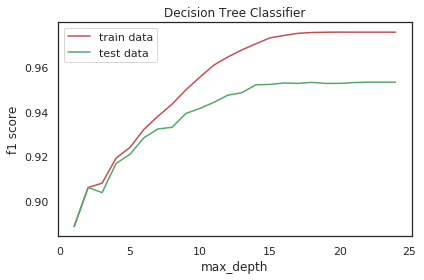

Decision Tree Classifier model time (s):   5.43338


In [10]:
tree_args = {'paramX': {'max_depth': list(range(1,25))}, 
             'helper_params': {'random_state': 0, 'min_samples_leaf': 3, 'criterion': 'gini'}}

plot_learner_graph(Xpw, Ypw, DecisionTreeClassifier, 'Decision Tree Classifier', **tree_args)

##### Neural network

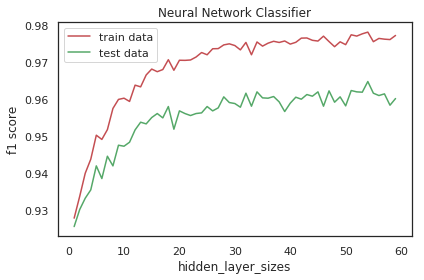

Neural Network Classifier model time (s):   705.41541


In [11]:
nn_args = {'paramX': {'hidden_layer_sizes': [(i,) for i in range(1,60)]}, 
           'helper_params': {'random_state': 0, 'learning_rate_init': 0.05, 'activation': 'relu'}}

plot_learner_graph(Xpw, Ypw, MLPClassifier, 'Neural Network Classifier', **nn_args)

##### Boosting with Decision Trees

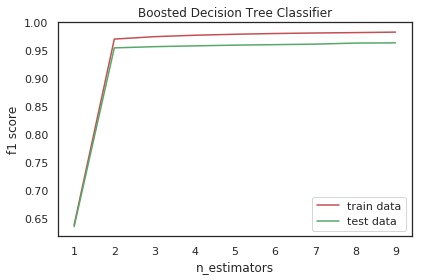

Boosted Decision Tree Classifier model time (s):   44.53678


In [12]:
boost_args = {'paramX': {'n_estimators': list(range(1,10))}, 
              'helper_params': {'random_state': 0, 'max_depth': 15, 'min_samples_leaf': 3}}

plot_learner_graph(Xpw, Ypw, GradientBoostingClassifier, 'Boosted Decision Tree Classifier', **boost_args)

##### Support vector machines

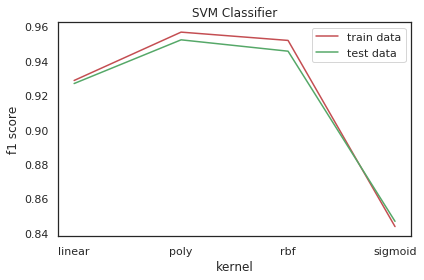

SVM Classifier model time (s):   94.10511


In [13]:
svm_args = {'paramX': {'kernel': ['linear','poly','rbf','sigmoid']}, 
            'helper_params': {'random_state': 0, 'gamma':'scale'}}

plot_learner_graph(Xpw, Ypw, SVC, 'SVM Classifier', **svm_args)

##### KNN

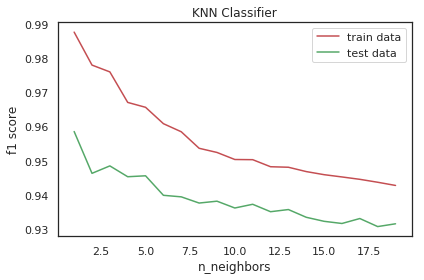

KNN Classifier model time (s):   636.56183


In [14]:
knn_args = {'paramX': {'n_neighbors': list(range(1,20))}, 
            'helper_params': {}}

plot_learner_graph(Xpw, Ypw, KNeighborsClassifier, 'KNN Classifier', **knn_args)

#### Wine quality data

In [15]:
# red wine data
df_rw = pd.read_csv(Path("winequality-red.csv"))

In [16]:
df_rw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [17]:
df_rw.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [18]:
df_rw.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [19]:
check_missing_val(df_rw)

no missing data


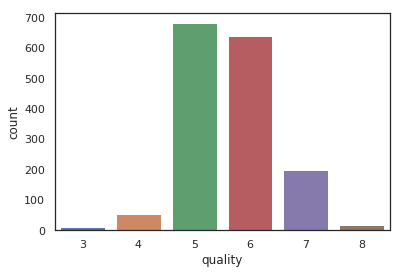

In [20]:
sns.countplot(x='quality', data=df_rw)
plt.show()

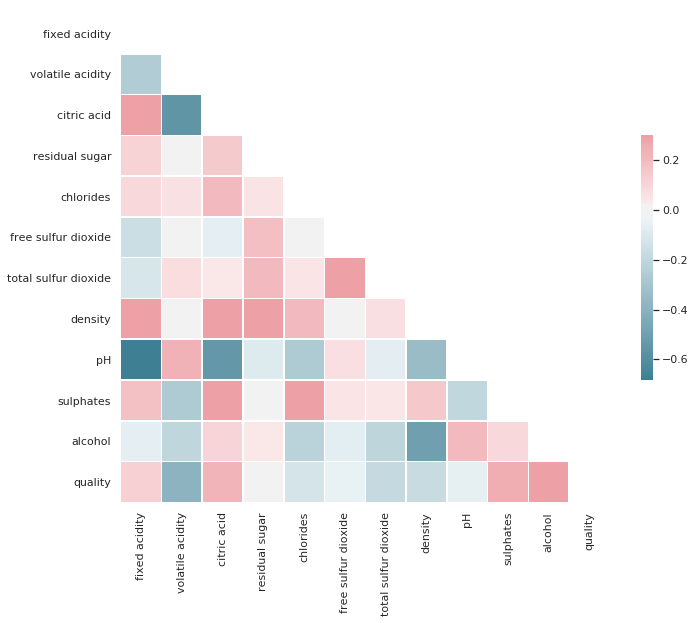

In [21]:
# Calculate the correlation
corr= df_rw.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [22]:
# remove unnecessary vars
df_rw.drop(["residual sugar",'free sulfur dioxide','pH'],axis = 1,inplace = True)

In [23]:
# Bin "quality" variable into three levels: poor, normal and excellent
bins = [0, 4, 6, 10]
labels = ["bad","good","excellent"]
df_rw['binned_quality'] = pd.cut(df_rw['quality'], bins=bins, labels=labels)
df_rw.head()
df_rw.drop('quality',axis =1, inplace = True)

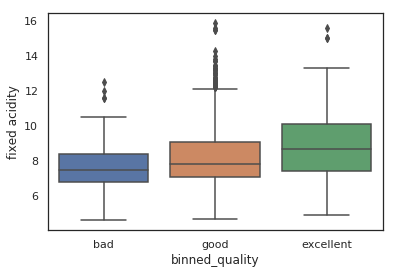

In [24]:
sns.boxplot(x="binned_quality", y='fixed acidity', data = df_rw)
plt.show()

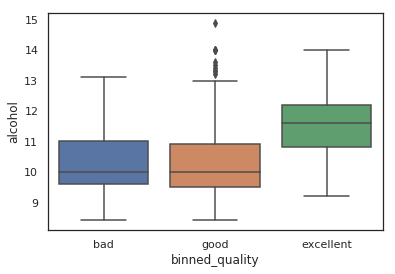

In [25]:
sns.boxplot(x="binned_quality", y='alcohol', data = df_rw)
plt.show()

In [26]:
label_quality = LabelEncoder()
df_rw['binned_quality'] = label_quality.fit_transform(df_rw['binned_quality'])

In [27]:
Xrw = df_rw.drop( "binned_quality",axis=1).values
Yrw = df_rw["binned_quality"].values

sc = StandardScaler()
Xrw = sc.fit_transform( Xrw )

##### Decision Tree

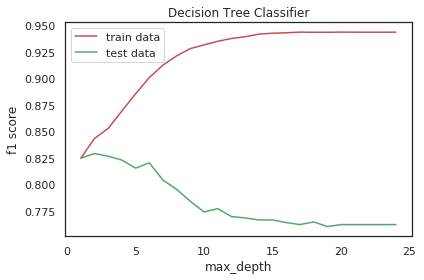

Decision Tree Classifier model time (s):   1.40424


In [28]:
tree_args = {'paramX': {'max_depth': list(range(1,25))}, 
             'helper_params': {'random_state': 0, 'min_samples_leaf': 3, 'criterion': 'gini'}}

plot_learner_graph(Xrw, Yrw, DecisionTreeClassifier, 'Decision Tree Classifier', **tree_args)

##### Neural Network

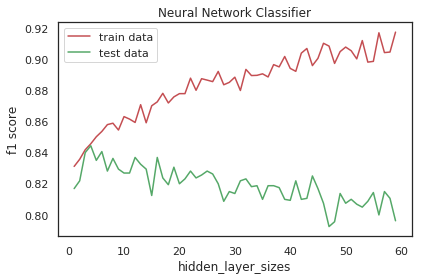

Neural Network Classifier model time (s):   157.82689


In [29]:
nn_args = {'paramX': {'hidden_layer_sizes': [(i,) for i in range(1,60)]}, 
           'helper_params': {'random_state': 0, 'learning_rate_init': 0.03, 'activation': 'relu'}}

plot_learner_graph(Xrw, Yrw, MLPClassifier, 'Neural Network Classifier', **nn_args)

##### Boosting with Decision Trees

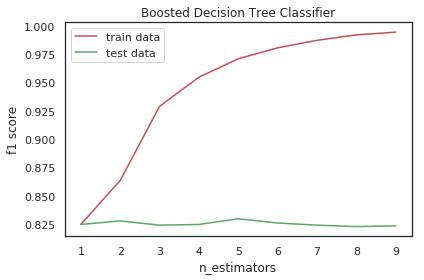

Boosted Decision Tree Classifier model time (s):   12.07985


In [30]:
boost_args = {'paramX': {'n_estimators': list(range(1,10))}, 
              'helper_params': {'random_state': 0, 'max_depth': 15, 'min_samples_leaf': 3}}

plot_learner_graph(Xrw, Yrw, GradientBoostingClassifier, 'Boosted Decision Tree Classifier', **boost_args)

##### Support vector machines

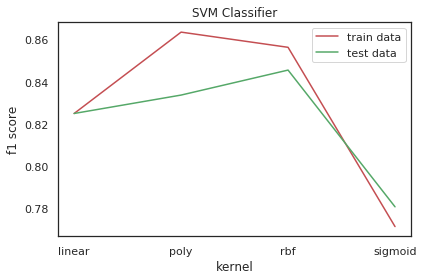

SVM Classifier model time (s):   2.12761


In [31]:
svm_args = {'paramX': {'kernel': ['linear','poly','rbf','sigmoid']}, 
            'helper_params': {'random_state': 0, 'gamma':'scale'}}

plot_learner_graph(Xrw, Yrw, SVC, 'SVM Classifier', **svm_args)

##### KNN

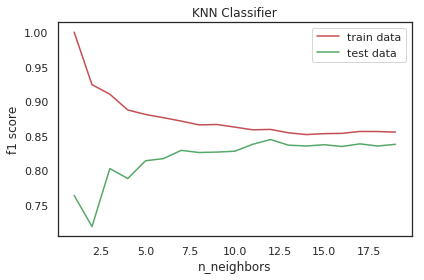

KNN Classifier model time (s):   4.98575


In [32]:
knn_args = {'paramX': {'n_neighbors': list(range(1,20))}, 
            'helper_params': {}}

plot_learner_graph(Xrw, Yrw, KNeighborsClassifier, 'KNN Classifier', **knn_args)

#### Gridsearch in SVM to find the best params

In [33]:
# Finding best parameters for our SVC model (take a long time)
param = {
    'C': [0.1, 0.3, 0.5, 0.7, 0.9, 1.2, 1.5],
    'kernel':['linear','poly','rbf'],
    'gamma' :[0.1, 0.3, 0.5, 0.7, 0.9, 1.2, 1.5]
}
grid_svc = GridSearchCV(SVC(), param_grid=param, scoring='accuracy', cv=10, n_jobs=-1)

In [34]:
grid_svc.fit(Xrw, Yrw)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.1, 0.3, 0.5, 0.7, 0.9, 1.2, 1.5], 'kernel': ['linear', 'poly', 'rbf'], 'gamma': [0.1, 0.3, 0.5, 0.7, 0.9, 1.2, 1.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [35]:
grid_svc.best_params_

{'C': 0.5, 'gamma': 0.3, 'kernel': 'rbf'}

In [36]:
grid_svc.best_score_

0.8436522826766729